In [1]:
# Standard libraries
import numpy as np
import json
import h5py
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "mesoscopic-functional-connectivity"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
from lib.info_metrics.projector_metrics import metric3D

from lib.stat import graph_lib
#from codes.lib.info_metrics.corr_lib import corr, crossCorr
from lib.data_io.qt_wrapper import gui_fnames, gui_fpath
from lib.data_io.data_fc_db import DataFCDatabase
import lib.plots.connectomics as connectomics
import lib.plots.connectomics_db as connectomics_db
import lib.plots.data_plots as data_plots
import lib.plots.data_plots_db as data_plots_db

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/mesoscopic-functional-connectivity


# Reading Data
* Automatically find subfolders for FC, data and behaviour
* Parse filenames and folders to identify mice, dates and analysis types
* Read all datasets into memory (so far works)

**TODO**:
* Integrate connectomics analysis with pandas

In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
params['root_path_data']  = gui_fpath("Path to data collection",  './')
#params['root_path_paw']   = gui_fpath("Path to Paw data",         params['root_path_data'])
#params['root_path_lick']  = gui_fpath("Path to Lick data",        params['root_path_paw'])
#params['root_path_whisk'] = gui_fpath("Path to Whisk Data",       params['root_path_lick'])
params['root_path_te']    = gui_fpath("Select TE results folder", params['root_path_data'])

In [3]:
dataDB = DataFCDatabase(params)

Target trial within [0, 8] sec. Total target timesteps 161
Searching for TE files
Total user files in dataset subsampled_delay_5_window_6 is 738
Searching for channel labels
Searching for data files
No paw path provided, skipping
No lick path provided, skipping
No whisk path provided, skipping


In [4]:
#display(dataDB.summary)
#display(dataDB.summaryTE)

In [5]:
dataDB.read_te_files()
dataDB.read_neuro_files()
dataDB.read_resample_paw_files()
dataDB.read_resample_lick_files()   # Currently does not work. Ask Yaro if we need it
dataDB.read_resample_whisk_files()

IntProgress(value=0, description='Reading TE files', max=738)

IntProgress(value=0, description='Read Neuro Data:', max=220)

Calculated performance 0.7264150943396226 does not match external 0.7333333333333333
Calculated performance 0.803680981595092 does not match external 0.808641975308642
Calculated performance 0.8411764705882353 does not match external 0.8436578171091446
Calculated performance 0.956989247311828 does not match external 0.9621621621621622
Calculated performance 0.6808510638297872 does not match external 0.6956521739130435
Calculated performance 0.9582366589327146 does not match external 0.9604651162790697
Calculated performance 0.4851258581235698 does not match external 0.4840182648401826
--Warning: For iMISS behaviour max index 437 exceeds nTrials 437
---Cropped excessive behaviour trials from 86 to 85
Calculated performance 0.42795389048991356 does not match external 0.6902017291066282
Calculated performance 0.2534562211981567 does not match external 0.30386740331491713
Calculated performance 0.4444444444444444 does not match external 0.47227191413237923
Calculated performance 0.56680161

--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_8 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_8 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyosha/Data/TE_data/yarodata/neuro/mvg48/mvg_9 ; Using calculated
--Warning: No performance metrics found for /media/alyos

In [6]:
pTHR = 0.7
dataDB.mark_days_expert_naive(pTHR)

# Analysis

## Performance

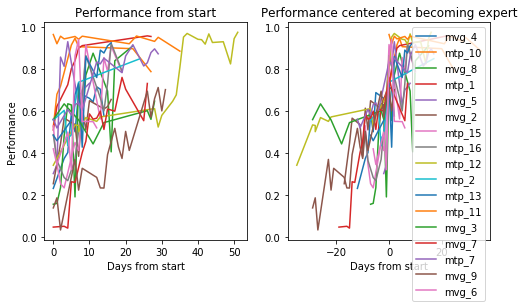

In [7]:
data_plots_db.plot_performance_by_days(dataDB)

IntProgress(value=0, description='Collecting std for data', max=119)

IntProgress(value=0, description='Collecting std for data')

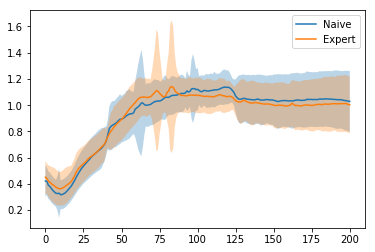

In [8]:
from codes.lib.plots.data_projectors import collect, plot_1D

metricParam = {'src_dim_order' : "rsp", 'trg_dim_order' : "s", 'zscoreDim' : "sr"}

metricNaive = collect(dataDB, {"isExpert" : False}, "std", metricParam)
metricExpert = collect(dataDB, {"isExpert" : True}, "std", metricParam)
# metric = collect(dataDB, {"mousename" : "mvg_8"}, "mean", metricParam)

fig, ax = plt.subplots()
# plot_1D(ax, metric)
plot_1D(ax, metricNaive, label='Naive')
plot_1D(ax, metricExpert, label='Expert')
plt.legend()
plt.show()

## Data Exploration

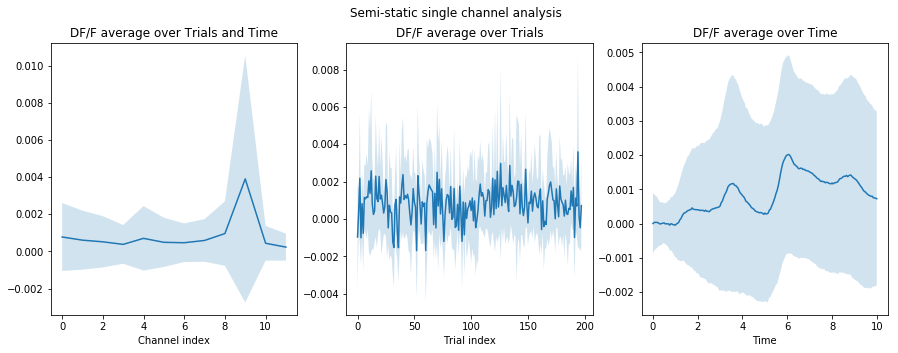

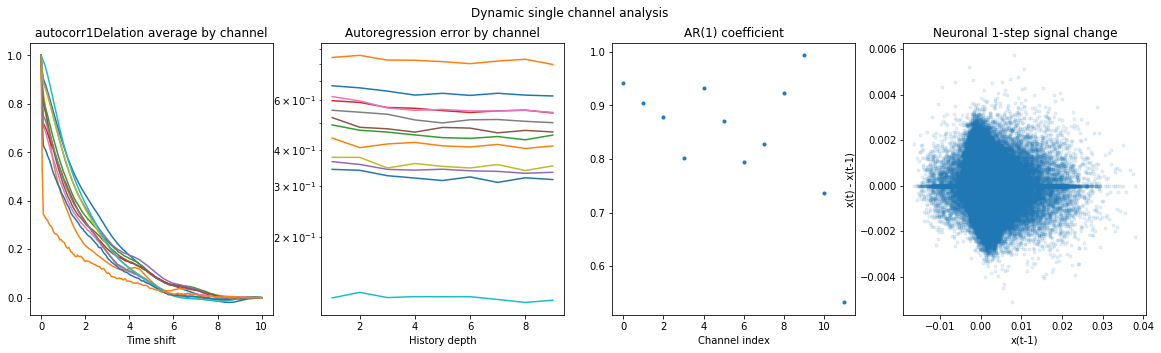

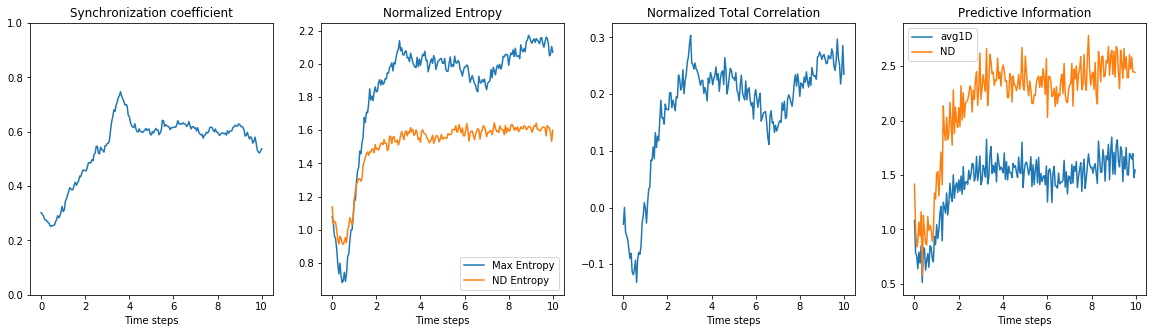

In [11]:
FPS = 20
dataThis = dataDB.dataNeuronal[0]

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
fig.suptitle("Semi-static single channel analysis")
data_plots.plot_mean_variance_bychannel(ax[0], dataThis)
data_plots.plot_mean_variance_bytrial(ax[1],dataThis)
data_plots.plot_mean_variance_bytime(ax[2], dataThis, fps=FPS)

fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
fig.suptitle("Dynamic single channel analysis")
data_plots.plot_autocorrelation_bychannel(ax[0], dataThis, fps=FPS, withFill=False)
data_plots.plot_ar(ax[1], ax[2], dataThis, histMax=10, fps=FPS)
data_plots.plot_fit_gamma(ax[3], dataThis)

fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
data_plots.plot_mean_correlation_bytime(ax[0], dataThis, fps=FPS)
data_plots.plot_entropy_ND_bytime(ax[1], ax[2], ax[3], dataThis, fps=FPS)

plt.show()

# Functional Connectivity

# **TODO**:
* Make sure all routines work
* If necessary, convert some routines to seaborn
* Remove ugly white bezel for circles
* Redo everything for downsampled data
* Rewrite rangeByDays to normalized days

* Impl ranges generic for all procedures
    - Get rid of timestep and rangesSec parameter for final routines
    - Uniform rangesSec only for generic plot, only one tuple (secStart, secEnd)
    - Impl routine for ranged FC extraction directly in dataDB

* Delete all procedures that are not in use
* Parallelize plotting

For Naive BivariateTE mean log p-val is -4.5472317290635
For Expert BivariateTE mean log p-val is -7.680966127612368
For Naive MultivariateTE mean log p-val is -2.219540112553524
For Expert MultivariateTE mean log p-val is -3.6146680221197087


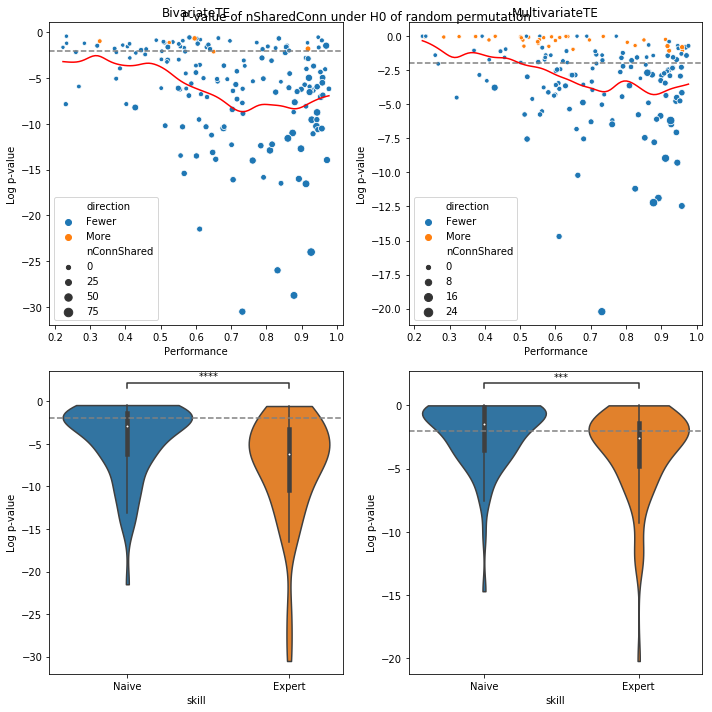

In [16]:
#rangesSec = {"report":(6, 6.5)}
rangesSec = {"whisk":(3, 3.5)}
#rangesSec = None

# connectomics_db.plot_generic(dataDB, pTHR, './', "connectivity_nconn_vs_time", rangesSec=rangesSec, ext='.svg')
# connectomics_db.plot_generic(dataDB, pTHR, './', "connectivity_nconn_vs_days", rangesSec=rangesSec, ext='.svg')
# connectomics_db.plot_generic(dataDB, pTHR, './', "connectivity_fc_vs_time", rangesSec=rangesSec, ext='.svg')
# connectomics_db.plot_generic(dataDB, pTHR, './', "connectivity_fc_vs_days", rangesSec=rangesSec, ext='.svg')
# connectomics_db.plot_generic(dataDB, pTHR, './', "connectivity_avgnconn_vs_days", rangesSec=rangesSec, ext='.svg')
# connectomics_db.plot_generic(dataDB, pTHR, './', "connectivity_fc_vs_performance", rangesSec=rangesSec, ext='.svg')
## connectomics_db.plot_te_shared_link_scatter(dataDB, pTHR, {"whisk":(3, 3.5)}, "./", ext='.svg')
# connectomics_db.plot_fc_vs_performance(dataDB, 0.01)
connectomics_db.plot_fc_binary_shared_pval_vs_performance(dataDB, 0.01, trial='iNOGO', outname='pval_12joint_all_all_raw.svg', filter12=True, rangesSec=rangesSec)

### Shared links

1. For each mouse, sort sessions by day
2. For each session, get links as any(isconn(range(3-3.5 sec)))
3. For nearby sessions of same mouse, calc shared_true, and shared_emp_distr

Intermediate Plots:
    * shared_true vs performance for union of all mice
    * 3D plot std(shared_emp_distr) as func of (nConnPre, nConnPost)
    
4. Sweep performance with window. There will be several points in each window
5. Define log-likelihood $L = -2 \log \prod_i P[s_i | H_0]$ where $P$ is the empirical distribution
6. Compute true log_likelihood $L_{true}$
7. Resample empirical distributions of points in the window to construct a set of random log-likelihoods
8. Find P-value as $p = P[L_{true} > L_{rand}]$

## 1. Correlation and Synchrony

**THINGS TO TRY**:
1. MI instead of TE
2. Some clustering measure
3. Repeat for other mice

NameError: name 'mice' is not defined

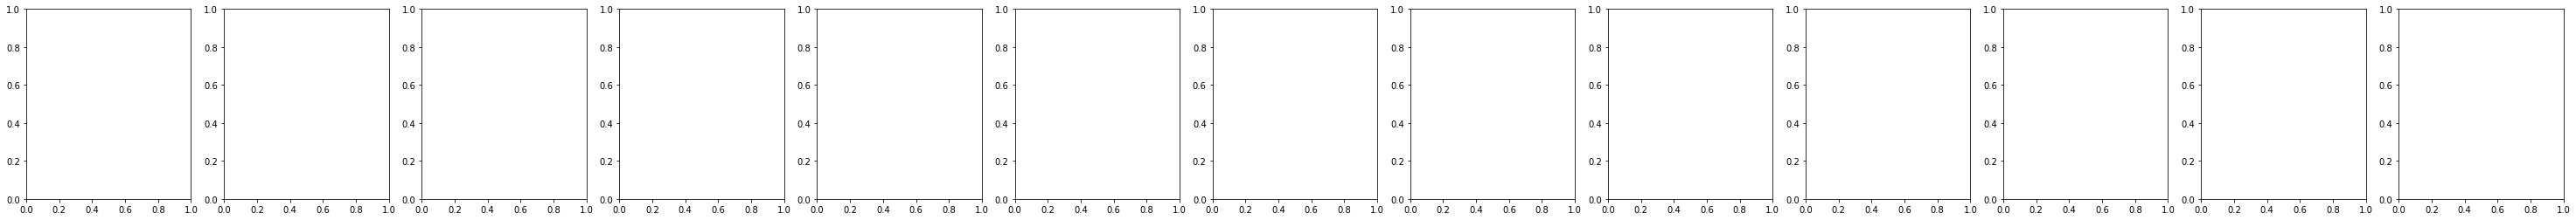

In [9]:
testNames = [
    "Mean Synchronization",
    "STD Synchronization",
    "Maximal Offdiag Value",
    "Mean weighted in-degree",
    "STD weighted in-degree",
    "Mean weighted out-degree",
    "STD weighted out-degree",
    "Average normalized total CC",
    "Average non-normalized total CC",
    "Average normalized in CC",
    "Average non-normalized in CC",
    "Average normalized out CC",
    "Average non-normalized out CC"]
nTest = len(testNames)

fig, ax = plt.subplots(ncols=nTest, figsize=(nTest*4, 4))

for mousename in mice:
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:    
        dataIdxs = list(mouseData["date"].index)
        
        testResults = np.zeros((len(dataIdxs), nTest))
        for i, dataIdx in enumerate(dataIdxs):
            # Compute cross-correlation absolute value
            dataThis = dataNeuronal[dataIdx].transpose(2,1,0) #channel x time x trial for cross-corr
            cAbs = np.abs(crossCorr(dataThis, 0, 0)[0])
            
            # Compute connectivity metrics
            testResults[i] = np.array([
                *graph_lib.diagonal_dominance(cAbs),
                np.max(graph_lib.offdiag(cAbs)),
                np.mean(graph_lib.degree_in(cAbs)),
                np.std(graph_lib.degree_in(cAbs)),
                np.mean(graph_lib.degree_out(cAbs)),
                np.std(graph_lib.degree_out(cAbs)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='tot', normDegree=True)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='tot', normDegree=False)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='in', normDegree=True)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='in', normDegree=False)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='out', normDegree=True)),
                np.mean(graph_lib.cl_coeff(cAbs, kind='out', normDegree=False))
            ])
            
        for iTest in range(nTest):
            ax[iTest].plot(deltaDaysCentered[dataIdxs], testResults[:,iTest], label=mousename)

for iTest in range(nTest):
    ax[iTest].set_title(testNames[iTest])
    ax[iTest].set_xlabel("Days from start")
    #ax[iTest].legend()
plt.show()

## 1.2 Clustering of data

1. For each mouse, for each time, compute corr
2. Compute CC vs time (mean/var)
3. Plot for all mice
4. Then split Go/NoGO

In [ ]:
trialKeys = ['iGO', 'iNOGO']
nTrialKeys = len(trialKeys)


for mousename in mice[:1]:
    print(mousename)
    
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:
        dataIdxs = list(mouseData["date"].index)
        
        fig, ax = plt.subplots(ncols=nTrialKeys, figsize=(5*nTrialKeys,5))
        fig.suptitle(mousename)
        
        for iKey, trialKey in enumerate(trialKeys):
            for i, dataIdx in enumerate(dataIdxs):
                
                
                dataLabel = pathDataSets['data_path']['mousekey'][dataIdx]
                trialIdx = dataTrials[dataIdx][trialKey]
                dataThis = dataNeuronal[dataIdx][trialIdx-1]

                print("--", dataLabel, trialKey, len(trialIdx))

                nTrial, nTime, nChannel = dataThis.shape

                ccNoNorm = np.zeros(nTime)
                for iTime in range(nTime):
                    corrAbs = np.abs(corr(dataThis[:, iTime, :].T))
                    ccNoNorm[iTime] = np.mean(graph_lib.cl_coeff(corrAbs, normDegree=False))

                ax[iKey].plot(ccNoNorm, label=dataLabel)

            ax[iKey].set_title(trialKey)
            ax[iKey].legend()
plt.show()

In order to evaluate the stability of emergent FC networks, we have designed a test based on the probability distribution of the number of the FC links shared between consequent sessions. The number of links observed in any given session is computed by summing up the entries of the corresponding binary FC matrix $M$.

$$N = \bigl| M \bigr|$$

Note that there are no self-connections, so $diag(M) = 0$. The number of shared links, $N_{sh}$, is defined as the sum of entries of the overlap between the two binary FC networks for consequent sessions. We will denote the "previous" session with $x$ and the "next" session with $y$

$$N_{sh}(x,y) = \bigl| M_x \cap M_y \bigr| $$

We can summarize a few constraints for $N_{sh}$
* $N_{sh} \geq 0$ - It is non-negative
* $N_{sh} \leq N$ - It does not exceed the total number of shared links
* $N_{sh} \leq \min(N_x, N_y)$ - It does ot exceed the lowest number of links among the overlapped matrices
* $N_{sh} \geq \max(0, N_x + N_y - N)$ - If the $N_X$ + $N_y$ exceed $N$, there is a guaranteed non-zero overlap between $M_x$ and $M_y$

Here, $N$ is the total number of possible shared links, which is given by the total number of the off-diagonal entries of the connectivity matrix. Given the number of channels $N_{ch}$ (equivalently, $shape(M) = [N_{ch} \times N_{ch}]$), the total number of the off-diagonal entries is given by

$$N = N_{ch}(N_{ch} - 1) / 2$$

We construct the following null hypothesis $H_0$: For all sessions $t$ the FC of $M_t$ is completely random. In this case, given the knowledge of the total number of observed links $N_t$, the probability distribution of the connectivity matrix under $H_0$ is given by a uniform random permutation of $N_t$ elements of $N$

$$P \bigl[M_t \bigr| N, N_t, H_0 \bigr] = Perm(N_t, N)$$

We can also calculate the probability distribution of the number of shared links $N_{sh}$ under $H_0$. The denominator is given by the number of possible permutations of $M_x$ and $M_y$. The numerator is constructed by first choosing $N_y$ from $N$, then choosing $N_{sh}$ from $N_y$, and finally distributing the non-shared links of $M_x$ among the remaining zeroes of $M_y$

$$P[N_{sh} | N,N_x,N_y, H_0]
= \frac{{N_y \choose N_{sh}}{N^{\max} - N_y \choose N_x - N_{sh}}{N^{\max} \choose N_y}}{{N^{\max} \choose N_x}{N^{\max} \choose N_y}}
= \frac{{N_y \choose N_{sh}}{N^{\max} - N_y \choose N_x - N_{sh}}}{{N^{\max} \choose N_x}}
$$

We use the above distribution in order to calculate the p-values of the following two-sided tests
* $p_{less} = P[N_{sh} \leq N_{sh}^{observed} | H_0]$ - The probability of getting as few of fewer shared links as observed
* $p_{more} = P[N_{sh} \geq N_{sh}^{observed} | H_0]$ - The probability of getting as many of more shared links as observed

We use the above tests to demonstrate that the number of the observed shared links is consistently very unlikely under $H_0$, proving that $H_0$ does not hold for the observed data. This implies that the overlap between consequent sessions is significantly different from a purely random one. Further, we use $S = \log p_{more}$ as a measure of stability of the network. The larger the absolute value of $S$, the more shared links there are, and the more stable is the network. We have also considered using $\frac{N_{sh}}{N}$ and $\frac{N_{sh}}{N_x}$ as measures of stability. However, the probability distribution of $N_{sh}$ is a non-trivial function of $N, N_x$ and $N_y$, and thus simplified metrics exhibit significant unexplained variance due to the variance of ignored parameter(s). We found that, while the empirical distributions of $S$ were different for 12 and 48 channel mice, they were much more consistent than those of the alternative metrics of stability we considered.

We have plotted $S$ as a scatter plot of performance in order to demonstrate the relationship between the network stability and learning. The scatter plot combines the results of all consecutive session pairs from all mice. We have also performed a Wilcoxon rank-sum test in order to determine whether the networks were more stable for expert or naive mice. We have opted for visualising the test results using violin plots because the empirical distributions of $S$ are highly asymmertic, and thus are difficult to accurately represent using bar plots. Finally, we used a sliding window to construct a trendline for the scatter plot in order to show the dynamic changes of stability with learning. For any given window, the likelihood of observing all data points in that window is given by

$$\Lambda = \prod_i P[N^i_{sh} | H_0]$$

and the associated log-likelihood

$$\lambda = \log \Lambda = \sum_i \log P[N^i_{sh} | H_0]$$

The log-likelihood is a linear function of the number of data points in the window $N_w$, so we normalized the log-likelihood with that number. Thus, the trendline is the the arithmetic mean of the logarithms of individual probabilities, which translates to the geometric mean of the probabilities themselves.

$$\frac{1}{N_{w}} \lambda = \frac{1}{N_{w}}\sum_i \log P[N^i_{sh} | H_0] = \log \sqrt[N_{w}]{ \prod_i P[N^i_{sh} | H_0]}$$

In order to smoothen the trendline, we replaced the window-based estimation of running average with kernel smoothening. We used a gaussian kernel with $\sigma^2 = 0.005$ units of performance squared.